![](https://drive.google.com/uc?export=view&id=1-5X9OUkA-C2Ih1gOS9Jd7GmkTWUEpDg1)

# Modelamiento no linea, validación cruzada y regularización


## Introducción a Data Science

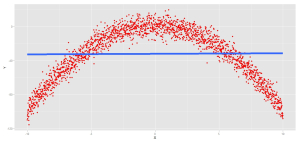

Profesor: Juan Bekios Calfa

Carreras: ICCI, IECI e IenCI

In [ ]:
### PREAMBLE
# Nonlinear modeling, overfitting, and regularization
# nonlinear.svg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Nonlinear Modeling and Generalization

This set of notes really deals with two different topics: nonlinear modeling and the issue of generalization.  These are really two separate and distinct issues in machine learning, but they arise very naturally in contection with each other, and so we choose to introduce there at the same time here.  Nonetheless, it is important to also understand that they are different topics, and that generalization issues can arise for any type of classifier (linear or nonlinear), and than nonlinear hypothesis functions are of independent interest.  With this caveat in mind, though, let's see how they can arise together.

## Nonlinear modeling

To introduce the issue of nonlinear modeling, let's return our original example of predicting peak electrical demand from high temperature.  Let's load the data we used last time (though this time we won't load from the raw files but just load the data frame we created last time from a CSV file, to see how to load from the raw data, see the ML intro notes).

In [ ]:
import pandas as pd
df = pd.read_csv("temp_demand.csv", index_col="Date")

Last time we considered the high temperature and peak demand in the summer months, obtained as follows.

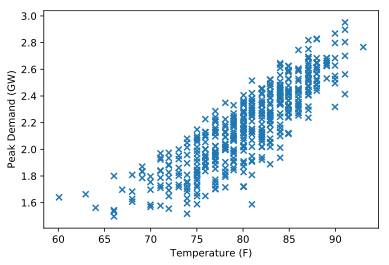

In [ ]:
df_summer = df[list(map(lambda x : str(x)[4:6] in ["06", "07", "08"], df.index))].copy()
plt.scatter(df_summer["Temp"], df_summer["Load"], marker='x')
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")

As we discussed, the relationship between high temperature and electrical demand is well-modelled by a linear function during the summer months, when (at least in Pittsburgh), electricity in summer is dominated by air conditions (so with higher temperatures comes higher consumption).  However, this is clearly not the case of the entire year.  Indeed, if our previous linear model is to be believed then with lower temperatures we would continue to have lower and lower consumption (until, at some point, we'd start generating electricity).  Naturally, this is not the case, and if we instead consider the _entire_ year of temperature and peak dmeand, then another picture emerges.

(0, 95)

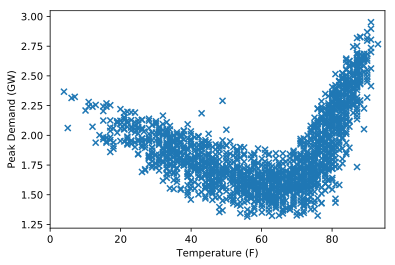

In [ ]:
plt.scatter(df["Temp"], df["Load"], marker="x")
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")
plt.xlim([0,95])

This captures the effects we expect.  Although peak demand increases sharply with consumption after a high temperature of 70 degrees or so (precisely the range where air conditioning usually starts), below this the demand actually start to increase with _lower_ temperature -- though not with as steep a slope, due to the fact, for example, that most heating in Pittsburgh is done with gas rather than with electricity, and other loads that do increase with lower temperatures tend to be smaller in magnitude that air conditions.

If we were to fit a linear model to this data, it would look like the following.

(0, 95)

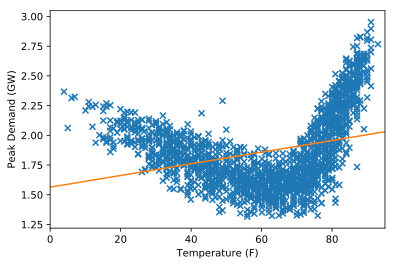

In [ ]:
X = np.array([df["Temp"].values, np.ones(len(df))]).T
y = df["Load"].values
theta = np.linalg.solve(X.T @ X, X.T @ y)
plt.scatter(df["Temp"], df["Load"], marker="x")
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")
plt.plot([0,100], [theta[1], 100*theta[0]+theta[1]], 'C1')
plt.xlim([0,95])

In a very precise sense this _is_ the best fit to the data: it is the line that minimizes the sum of squared errors between the data points and the points on this line (remember, this is the definition of linear regression).  However, of course in another sense this is a very poor fit, as it misses the defining characteristic of the data, namely that peak demand has this characteristic of first gently decreasing with higher temperature up to about 70 degrees, then increasing rapidly.

To capture data of this type, we clearly want some way of expressing nonlinear relationships in the data.  Fortunately, this is possible without actually leaving the domain of so-called "linear regresion".  The trick we are going to use is a simple one: rather than have features $x^{(i)}$ which only include the "raw" inputs such as temperatuare (plus other raw inputs such as weekday indicators that we saw previously), we are going to make build features that include _nonlinear_ functions of the underlying inputs.  For example, we could choose the following features
\begin{equation}
x^{(i)} = \left [ \begin{array}{c} (\mathrm{HighTemperature}^{(i)})^2 \\
\mathrm{HighTemperature}^{(i)} \\ 1 \end{array} \right ]
\end{equation}
which also include a quadratic function of the high temperature variable.  If we choose this representation, then our linear hypothesis function $h_\theta(x) = \theta^Tx$ is now given by
\begin{equation}
h_\theta(x) = \theta_1 (\mathrm{HighTemperature}^{(i)})^2 + \theta_2 \mathrm{HighTemperature}^{(i)} + \theta_3
\end{equation}
which is a _quadratic_ function of the high temperature.  Importantly, however, the hypothesis function is still a linear function of the parameters, and so the exact same solution methods work as before (including the exact solution), just by passing a different feature matrix.

Let's see how this works in practice.  In this setting we're actually going to normalize features to the range $[-1,+1]$ even with the exactly least-squares solution for numerical reasons.  High polynomials get very large very quickly, and if we aren't careful it's easy to overload the range of double precision floating point values.

In [ ]:
x = df["Temp"].values
min_x, max_x = x.min(), x.max()
x = 2*(x - min_x)/(max_x - min_x) - 1

def ls_poly(x, y, degree):
    X = np.array([x**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X, X.T @ y)

theta = ls_poly(x, y, 2)
print(theta)

[ 1.19886894 -0.19235301  1.5888731 ]


Now that we've computed the solution, let's plot is as before.  Since our hypothesis is no longer a line we can't plot it by simply specifying two points, but the rough procedure works the same as before.

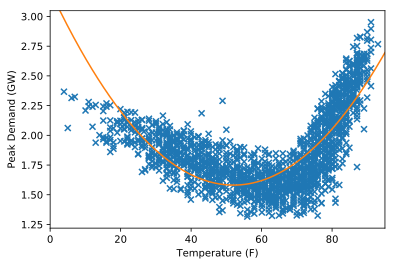

In [ ]:
def plot_regression_poly(theta):
    degree = len(theta)-1
    xt0 = np.linspace(0,95, 400)
    xt = 2*(xt0 - min_x)/(max_x - min_x) - 1
    Xt = np.array([xt**i for i in range(degree,-1,-1)]).T
    yt = Xt @ theta
        
    plt.scatter(df["Temp"], df["Load"], marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (F)")
    plt.ylabel("Peak Demand (GW)")
    plt.xlim([0,95])
    plt.ylim(ylim)
    
plot_regression_poly(theta)

This looks better, but quadratic function is symmetric around its minimum point, and the data we're trying to fit is definitely not symmetric. Thus, we may want a cubic function.

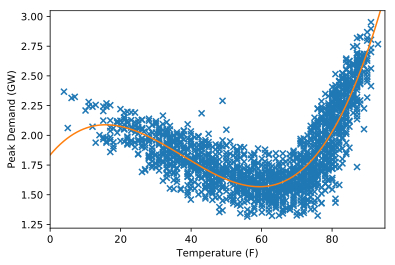

In [ ]:
plot_regression_poly(ls_poly(x,y,3))

This looks better except for the low end, so maybe one more degree.

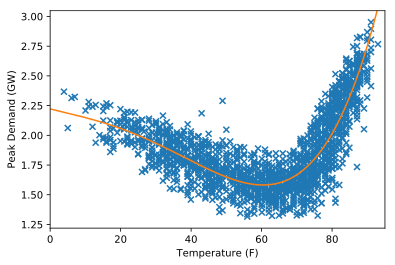

In [ ]:
plot_regression_poly(ls_poly(x,y,4))

This is starting to look like a pretty good fit to the data.  But so far high degree has been better, so let's keep going, trying a degree 10 polynomial.

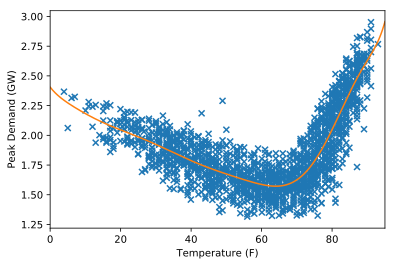

In [ ]:
plot_regression_poly(ls_poly(x,y,10))

Still not bad.  Let's keep going.

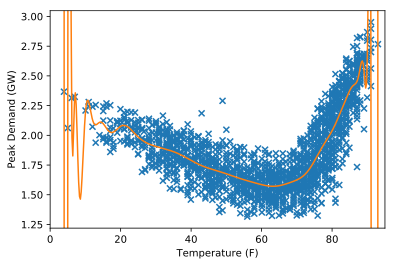

In [ ]:
plot_regression_poly(ls_poly(x,y,100))

Something very bad has happened at this point.  Especially at the tail ends of the data, where the data points are spaced less closely, we start to get very odd patterns for the data.  But the important point is that this is actually a very good fit to the data from a least-squares perspective.  As you can see from the figure, the lines pass _exactly_ through many of the data point (most obvious on the left hand side of the plot), whereas for the "better" fits we had above, our function didn't pass exactly through those points, so actually suffered more loss.  But there is an obvious way in which the degree 100 polynomial fit, despite having _lower_ loss, is actually a worse approximation to the underlying data.  This brings us to the second topic of these notes, which is the issue of generlization and overfitting.

## Generalization and overfitting

Recall from our previous discussions that the canoncial machine learning problem that we solve with every algorithm is the following
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \; \frac{1}{m}\sum_{i=1}^m \ell \left(h_\theta(x^{(i)},y^{(i)} \right)
\end{equation}
i.e., to minimize the sum of losses on the data set.  However, in a more fundamental way, this is not really our goal.  We ultimately do not care about achieving low loss specifically on the points that we are feeding into the algorithm: we already _know_ the true output for each of these data points, and if we want to "predict" these points precisely, we could just look up each point in a database (assuming we have some way of referring to the points uniquely).  What we _really_ want from a machine learning algorithm is the ability to predict will on _new_ data points _of the same type_ as those we learned our model on.  We don't care about knowing was the peak demand _was_ on previous days we have already seen; we care about being able to predict what the peak demand will _be_ tomorrow given the high temperature as input.

**Generalization error** This discussion leads us to the notion of _generalization error_.  Informally, the generalization error is just the error (or more generally, the loss) we would experience not on the training data itself, but on new data drawn from the "same distirbution" as the training data.  _This_ is really the quantity we want to minimize, not the error on the training data itself.  Because when we run our machine learning algorithm on new data, all that will matter is its generalization performance.

What the above example illustrated was an instance of _overfitting_, the situation where the training error is low, but the generalization error is high.  This occurs because we are explicitly trying to minimize the loss on the training set, and if the expressiveness of of hypothesis function is small enough, then we can make this loss arbitrarily small, usually by fitting to pecularities in the training data that provide no real benefit when looking at new data.

**Overfitting in least squares** As a simple example, let's consider the the case of least squares regression, when we choose the number of features $n$ to be the same as the number of examples $m$ (for example, we could achieve this by choosing a very high degree polynomial); let's also assume that that the underlying data is distinction for each data point, which will imply (we won't worry about proving this formally, you can just take it as a fact) that that features for each example a linearly independent.  Then we can look at our least squares solution
\begin{equation}
\begin{split}
\theta & = (X^T X)^{-1} X^T y   \\
& = X^{-1} X^{-T} X^T y \\
& = X^{-1} y
\end{split}
\end{equation}
(where the assumption about linear independence implies that $X$ is invertible, and we use the property that $(AB)^{-1} = B^{-1} A^{-1}$ when $A$ and $B$ are invertible) and we therefore have $X\theta = y$, i.e., the predictions on the training set are perfect.  However, unless the model was exactly capture by $m$ points, there would be no reason to expect tha the resulting fit would generalize well to new points. 

**Overfitting and model complexity**

In general, we expect something like the following behavior when it comes to overfitting.  We're showing the "cartoon" form here but we will shortly see what this looks like in practice.

![Cartoon illustration of overfitting](overfitting.svg)

When model complexity is low, both training and generalization loss are high (here model complexity can mean any type of representational power of the model, but since we have covered this so far, you can think of it just as the degree of the polynomial in our feature vector).  As we increase model complexity, the both training and generalization performance start to decrease with training loss usually slightly lower that generalization loss (due to the simple fact tha we explicitly optimized training loss).  As we futher increase model complexity, training loss will continue to only decrease: by adding additional representational power to our model, we will only fit the data better and better, since we are explicitly choosing parameters to minimize this loss.  But at a certain point, generalization loss will start to increase again.  Our goal when choosing the "right" model for a particular machine learning problem is to find the model with lowest generalization error, the minimum in the red line above.  However, we cannot do so using the training set alone, because performance on the training set (the blue line), gives us no clue at to the performance of the generalization loss.

### Cross validation

The fundamental idea we're going to use here is simple enough that you have likely already thought of how to do this, even if you haven't seen the process before.  Although we cannot easily have access to the _true_ generalization loss (this is an expectation over the true underlying distribution of data, as we will define shortly).  However, we can easily obtain a reasonable approximation to it by a procedure called cross validation.

![Simple 70-30 cross validation split](cv_split.svg)

The idea of cross validation is simple.  Given the entirety of our training data, we take some fixed percentage, say 70% of the data, and call this our "new" training set.  We then take the remaining data (30% in this case), and call it the _holdout_ or _validation_ set.  The basic idea is that we will use the emprical error or loss on this holdout set as an approximation for the generalization error.  This works because, unlike the training set, we do _not_ choose the parameters of the model based upon the validation set.  This means that there is no way for the parameters to overfit to this data, and thus the validation set still provides a reasonable estimate of generalization error even _after_ the parameters have been trained.

**Note:** it is important that I explicitly have not used the work _test set_ above.  While training/testing set splits in many data science problems are created in a similar manner, there is something fundamentally different about a test set than a validation set, which we will discuss more when we talk about evaluating machine learning algorithms.

Let's see how to generate these training and validation sets.

In [ ]:
np.random.seed(10)
perm = np.random.permutation(X.shape[0])
idx_train = perm[:int(len(perm)*0.7)]
idx_cv = perm[int(len(perm)*0.7):]

x_train, y_train = df["Temp"].iloc[idx_train].values, df["Load"].iloc[idx_train].values
x_cv, y_cv = df["Temp"].iloc[idx_cv].values, df["Load"].iloc[idx_cv].values

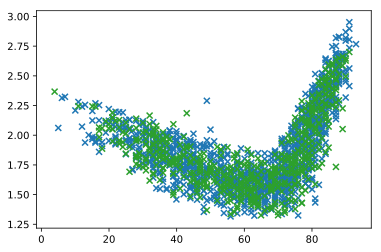

In [ ]:
plt.scatter(x_train, y_train, marker='x', color="C0")
plt.scatter(x_cv, y_cv, marker='x', color="C2")

Now let's generate features for the training and cross validation sets.  The standard procedure here is that we should compute all feature normalization based upon the training set alone, and only afterwards apply this same normalization to the test set.  Note that in some cases it is permissable to include cross validation data points (obviously not the labels) into the normalization process (namely if you expect to have similar access to all the "unlabled" data you will be evaluating the system on prior to training the system), but it's much more standard to simply use just the new training set for everything, including normalization.

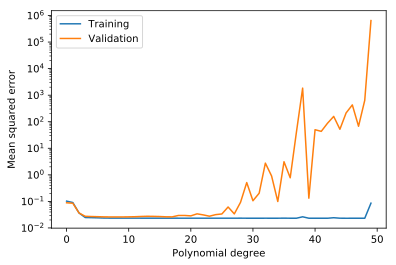

In [ ]:
min_x_train, max_x_train = x_train.min(), x_train.max()
x_train = 2*(x_train - min_x_train)/(max_x_train - min_x_train) - 1
x_cv = 2*(x_cv - min_x_train)/(max_x_train - min_x_train) - 1

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T
    

err_train = []
err_cv = []
for i in range(50):
    theta = ls_poly(x_train, y_train, i)
    err_train.append(((poly_feat(x_train,i) @ theta - y_train)**2).mean())
    err_cv.append(((poly_feat(x_cv,i) @ theta - y_cv)**2).mean())
plt.semilogy(range(50), err_train, range(50), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")

Don't worry about the little increases in training loss at the high end of the figure: these result from numerical instabilities that occur as you have polynomials that that high a degree (simply put, at this range the numerical accuracy of double precision is not high enough).  But the point here is hopefully clear, that as model complexity rises, training error decreses (modulo numerical stability), while cross validation error can increase greatly (notice we are using a log scale for the plot).  But it's also worth emphasizing that this is not a monotonic process: again due to peculiarities in the data, the cross validation loss can jump around significantly.  You want to pay more attention to the general tread instead of any particular value of the loss.

So which model is the "best" fit to the data.  This is a somewhat subjective question, since it likely involves some combination of a model with low cross-validation error _and_ some subjective notion about preferring "simpler" models all else being equal.  Let's look more closely at the range of low loss.

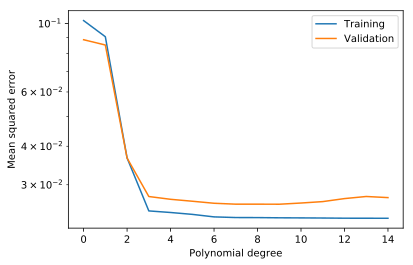

In [ ]:
plt.semilogy(range(15), err_train[:15], range(15), err_cv[:15])
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")

Looking at the plot, maybe a polynomial degree somewhere between six and eight looks like it has the lowest cross validation error.  Though it would also be reasonable, I think, to advocate for a polynomial of degree three, as the loss sharpely decreases up until this point, and then only improves to a minor degree afterwards, so we may want to prefer the simplicity of the degree three polynomial.

** Terminology: parameters and hyperparameters ** It is worth introducing a bit of notation here.  As we have done before, we refer to the parameters of the hypothesis function itself (i.e., $\theta$), just in this manner, as the _parameters_ of model.  Any additional elements, though, such as the degree of the polynomial (which is _not_ of the native parameter of the hypothesis function, as the hypothesis function assumes a given number of features), are referred to as _hyperpameters_.  The basic idea of cross-validation is that we use the training set to choose our parameters, while we use the cross-validation set to choose our hyperparameters.  We'll see more instances of hyperparameters shortly.

### K-fold cross validation

Another variant of cross-validation is common enough that it bears mentioning.  One potential issue with cross-validation is that we are "at the mercy" of a single random split of our data.  If one "outlier" data point appears in the training versus validation set, this could have a substantial influence on the reported accuracy of the method and the resulting choice of hyperparameters.  As as example, in the above setting we actually (intentionally, for the purposes of demonstration), picked a setting where one of the extreme points (the observation with lowest temperature) appeared in the validation set rather than the training set; because high-degree polynomial regression in particularly bad at extrapolating to data points outside the range of what was seen during training, this one point contributes substantially to the high cross validation error we see for high polynomial degrees.  But I would argue that this is actually realistic: we do expect there to be some points that lie outside the range of what we have seen before, and a reasonable ML method should have some ability to extrapolate at least to some small degree.  But had we split the data differently, we wouldn't see this behavior so dramatically (try out a few different random seed above to see this yourself).

This motivates a setting where _every_ point in the data is used at least once for validation.  We can accomplish this via _k-fold cross validation_.  The basic idea here is that instead of breaking the data set into a single training and validation set, we divide the dataset into $k$ approximately equal-sized segments, or folds.

![Illustration of dataset division for k-fold cross validation](kfold.svg)

After doing this, we then train and evaluate the model $k$ different times, using each fold as a validation set, and all the remaining folds as the training set, and then finally average the results together over all the folds.  This intuitively can provide a "better" estimate of the generalization error, because we are using every point in our data set as a validation point at least one time.  The trade off is that we now need to train $k$ times as many models (one for each collection of $k-1$ folds); for settings where we can run the algorithm very quickly, this is not too steep a cost, but when the algorithms are costly to run and when data is plentiful, it is more common to simply use traditional cross validation.

### Additional variants of cross validation

There are a few additional variants of cross validation that are common enough that you should be familiar with them.

**Leave-one-out cross validation ** This is the "natural" extreme of k-fold cross validation, the case where we choose $k=m$, i.e., a separate fold for each data point.  In this setting, we train on all put one of the examples, test on that one example, and repeat this $m$ times.  While this is typically very costly to compute (because it involves now solving $m$ different training problems), it somewhat surprisingly turns out that for least squares there are some linear algebra tricks we can play that make computing this quantity no worse (in terms of big-O notation) than comptuting a _single_ least squares solution.  This may seem quite surprising, and is another nice property of least squares.  But leave-one-out cross validation is also not perfect.  When running k-fold cross validation there is a tendency to think of each fold as a "separate trial" and thus the combination of $k$ of these trials could give us a very good estimate of the true generalization error.  But this is actually not correct: because the training process is highly correlated over the folds (they share the majority of the same data), they are not actually independent runs of the training/validation process, and so the accuracy of our generalization error estimate does not necessarily increase with the number of folds (in fact, it's hard to show from a theoretical perspective that there is much advantage to doing so at all).  Proving all this requires a more rigorous treatment of generalization and cross validation procedures, which we won't address here, but be aware of these issues insofar as they highlight that k-fold cross validation is not an ideal procedure for estimating the true generalization loss.

Finally, there are other reasons to avoid k-fold cross validation in some settings.  For instance, if we are considering a time series forecating problem, it always makes sense to build a validation set that occurs _after_ the training set, so that we aren't effectively predicting the past using the future.  And yes, we did actually make this mistake in our above example, where the data is temporal yet we used a random split of the data.  The underlying assumption we made is that the temperature/load relationship over the five years does _not_ depend on time, but in a more rigorous study we would probably want to validate this assumption further before using random splits for training/validation (or to be safe, just perform validation on the last year, and training on the first five, or something similar).

**Stratified cross-validation ** This type of cross-validation tries to keep some property (most commonly the proportion of positively and negatively labeled examples, but other options are possible too) consistent between the training and validation sets.  If, for instance, you have data that is highly unbalanced, with many more negative than positive labels, you may want to use stratified cross validation to ensure that you get a similar number of each type in the training and validation sets, to ensure that your results aren't unduly influenced by a "bad" random seed (for example, which might put very few or even no positive examples in the validation set, making the validation loss not very meaningful).

## Regularization

We have so far seen that the degree of the polynomial we use for our nonlinear features acts as a nice characterization of the model complexity.  But there is another notion of model complexity that is also important to understand, the _magnitude_ of the model parameters.  To see why this is important, let's look again at our degree 100 polynomial fit to the data.

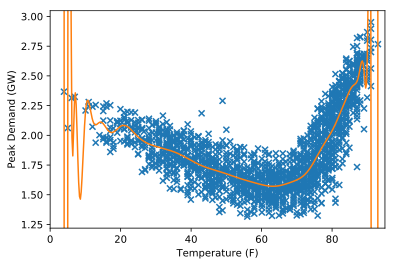

In [ ]:
plot_regression_poly(ls_poly(x,y,100))

Let's also look at the actual weights involvd with this fit.

In [ ]:
theta = ls_poly(x,y,100)
print(theta[:4])

[-225430.02270515  764586.40932062 -713994.9434542  -871745.10747298]


The way that we get the polynomial to _exactly_ pass through the points requires extremely high values for the coefficients: we need to set the coefficients just so that the different polynomial terms largely "cancel" out precisely at the data points and fit the function exactly to the data.

This also suggests another method for controlling the complexity of the model class: restircting the magnitude of the coefficients.  This is the basis of the technique known as _regularization_.

Formally, regularization is often written as an additional term in the canonical machine learning problem.  Instead of simply minimizing the average loss, we minimize the average loss plus a term that penalizes the magnitude of the coefficients (usually some function of a norm of the weights, often just the sum of squared weights also called $\ell_2$ regularization, but other functions are possible as well).  For example, let's consider the following optimizaiton problem:
\begin{equation}
\minimize_\theta \; \frac{1}{m}\sum_{i=1}^m \ell \left(h_\theta(x^{(i)},y^{(i)} \right) + \lambda \sum_{i=1}^n \theta_i^2
\end{equation}
where $\lambda \in \mathbb{R}_+$ is what is called a _regularization parameter_.  $\lambda$ effectively trades off between minimizing the training loss (which naturally "wants" to use large weights), and keeping the weights small.  If $\lambda = 0$, we ignore the regularization term entirely, and just minimize training loss; but as $\lambda \rightarrow \infty$, the _only_ relevant term in the optimization problem becomes the sum of the squared weights, which is clearly minimized if we just pick $\theta = 0$.  Thus, by varying $\lambda$ between zero and some very large constant, we can "sweep out" different ranges of model complexity.


### Regularization in least squares

Before visualizing what our regularized solutions actually look like, let's look at how to solve the regularized problem, at least in the least squares setting.  It will turn out for squared loss and a penalty on the squared weights, there is an exact solution to the regularized least-squares problem, just as there was with traditional least squares.

To see this, let's consider the objective with $\ell_2$ regularization and squared loss.
\begin{equation}
\minimize_\theta \; \frac{1}{m}\sum_{i=1}^m \left (\theta^T x^{(i)} - y^{(i)} \right) + \lambda \sum_{j=1}^n \theta_j^2
\end{equation}

Recall from our previous lecture that the gradientn with respect to $\theta$ of the squared loss term was just 
Taking the gradient of the objective with respect to $\theta$ we get
\begin{equation}
\nabla_\theta \frac{1}{m}\sum_{i=1}^m \left (\theta^T x^{(i)} - y^{(i)} \right) = $\frac{2}{m}X^T(X\theta - y)$
\end{equation}
so we just need to compute the gradient of the regularization term
\begin{equation}
\nabla_\theta \lambda \sum_{i=j}^n \theta_j^2.
\end{equation}
This particular term is actually very simple.  Since the partial derivative of the regularization term is just given by
\begin{equation}
\frac{\partial}{\partial \theta_k} \lambda \sum_{i=1}^n \theta_i^2 = 2 \lambda \theta_k
\end{equation}
we have the the whole gradient term in simply given by 
\begin{equation}
\nabla_\theta \lambda \sum_{i=j}^n \theta_j^2 = 2 \lambda \theta.
\end{equation}

Finding the least-squares solution therefore just involves finding the solution to the matrix equation
\begin{equation}
\begin{split}
& \frac{2}{m}X^T(X\theta^\star - y) + 2 \lambda \theta^\star = 0 \\
\Longrightarrow \;\; & (X^T X + m \lambda I) \theta^\star = X^T y \\
\Longrightarrow \;\; & \theta^\star = (X^T X + m \lambda I )^{-1} X^T y.
\end{split}
\end{equation}

Because the $m$ term there looks a bit cumbersome, it's common to simply wrap the constant $m$ into the regularization term itself, and write the regularized solution as 
\begin{equation}
\theta^\star = (X^T X + \lambda I)^{-1} X^T y
\end{equation}
which is the form we'll use to compute the regularized least squares solution below.

Note that the above discussion also provided us with a way of incorporating regularization into gradient descent procedures to: the gradient of the $\ell_2$ regularization term, for instance is just $2 \lambda \theta$, so in gradient descent we simply add this additional term to our gradients, and run the algorithm as we did before.  In fact, we already did this when we run our previous gradient descent algorithms for classification (the SVM explicitly has this regularization term included), and the formulation hopefully makes more sense after this discussion if it did not previously.

### Visualizing regularization



Let's see what this looks like on our 100 degree polynomial.  The figure above shows the situation with no regularization, i.e, $\lambda = 0$.  If we instead choose $\lambda = 1$, we get the following figure.

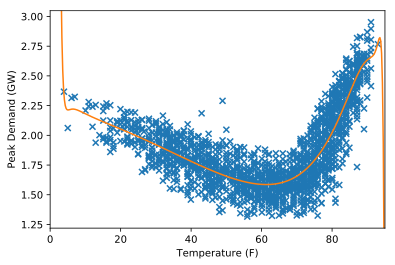

In [ ]:
def ls_poly_reg(x, y, lam, degree):
    X = np.array([x**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X + lam*np.eye(X.shape[1]), X.T @ y)

theta = ls_poly_reg(x, y, 1.0, 100)
plot_regression_poly(theta)

What happens outside the range of the data is still often poorly specified, but this looks substantially better what what we had before.  And we can indeed see that the magnitude of the parameters $\theta$ are much smaller.

In [ ]:
print(theta[:5])

[ 0.00567776 -0.02367691  0.00552413 -0.02264579  0.00538301]


What happens if we regularize further?  As we increase labmda, the underlying function becomes (again, focusing mainly here on the data between the extreme points) looks generally smoother.

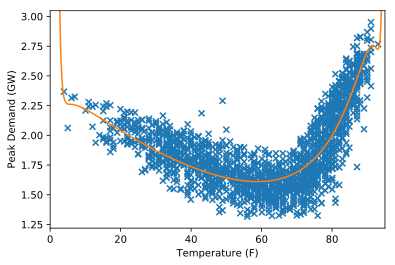

In [ ]:
theta = ls_poly_reg(x, y, 10.0, 100)
plot_regression_poly(theta)

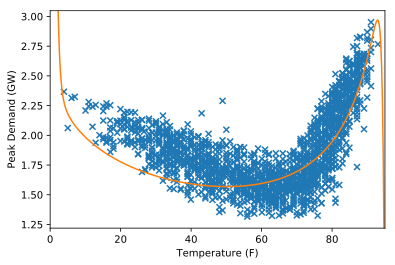

In [ ]:
theta = ls_poly_reg(x, y, 100.0, 100)
plot_regression_poly(theta)

We can also understand what is happening here by reference to the previous section when we discussed polynomial fittings as a function of the degree of the polynomial.  Remember that after degree 10 or so, there wasn't a huge benefit to including additional polynomial terms in the regression.  Yet, if include these terms within the context of a tradition least squares fit, we have seen that in order to use the polynomial degree to minimize the error (essentially done by "exactly" passing through some of the points), this is accomplished by have very high weight on the high-order coefficients.

So what happens when we apply a regularization penalty?  Because we know that we can achieve low error with a lower-degree polynomial of relatively small weights, if we add sufficient regularization to the optimization objective, this will have the effect of avoiding putting much weight on the high-order terms in the polynomial, and just putting the weight on the lower order terms.  We can view this by looking at the magnitude of the actual coefficients of $\theta$ before and after regularization (remember, $\theta$ is ordered in higher-to-lower degree polynomial terms, so we will flip the order to correspond to increasing degree of the polynomial terms.  First let's look at the magnitude of the coefficients (on a log scale), for the unregularized $\theta$.

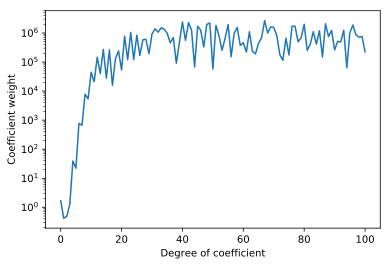

In [ ]:
theta = ls_poly(x, y, 100)
plt.semilogy(range(101), np.abs(theta[::-1]))
plt.xlabel("Degree of coefficient")
plt.ylabel("Coefficient weight")

Now let's look at the regularized version.

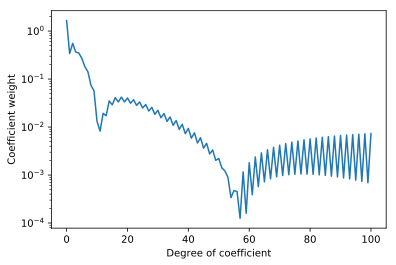

In [ ]:
theta = ls_poly_reg(x, y, 10.0, 100)
plt.semilogy(range(101), np.abs(theta[::-1]))
plt.xlabel("Degree of coefficient")
plt.ylabel("Coefficient weight")

Don't read anything here into the oscillating behavior of the coefficients at the higher degrees, this is just an artifact of the scaling of our polynomials.  The point to take away from this is that after degree 8 or so, the model puts very little relative weight on the coefficients.  And this makes perfect sense.  As the pllot showing degree of the polynomial versus (training) loss illustrated, we know that we can already fit the data well with a relatively low degree polynomial.  So penalizing high coefficients as as something like a "smooth" selection of which degree polynomial to use: because using high degree terms in the polynomial also requires using large weights, the regularization term naturally leads us to rely more heavily on the lower order terms.

### Regularization and cross-validation performance

We can also illustrate the effects of regularization as they relate to training and validation performance.  Just as we did with the degree of the polynomial, we can consider the training and validation errors for different amounts of regularization.

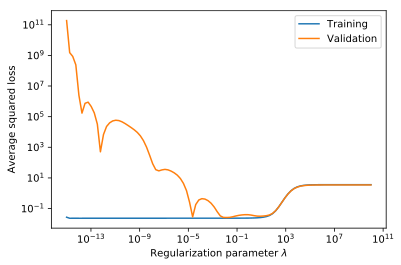

In [ ]:
lam = np.logspace(-15,10,100)

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T

phi_train = poly_feat(x_train, 100)
phi_cv = poly_feat(x_cv,100)
err_train = [((phi_train @ ls_poly_reg(x_train, y_train, l, 100) - y_train)**2).mean() for l in lam]
err_cv = [((phi_cv @ ls_poly_reg(x_train, y_train, l, 100) - y_cv)**2).mean() for l in lam]

plt.loglog(lam, err_train, lam, err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Regularization parameter $\lambda$")
plt.ylabel("Average squared loss")

A few points are worth emphasizing here.  First, note that this figure looks very similar to the previous one, except that the direction on the x-axis is reversed.  This makes sense due to the nature of the regularization term: lower $\lambda$ means _less_ regularization, whereas large $\lambda$ mean more regularization (eventually just essentially corresponding to all zero weights).  Thus, larger $\lambda$ means _lower_ model complexity, so the x-axis of the figure works in the opposite direction as in the polynomial degree example.  Second, also note that we are using a _logarithmic_ scale on the x-axis (and the y-axis, as before, but the x-axis is the important part here).  This means that regularization typically works on a scale of _orders of magnitude_.  If you search over possible regularization terms, you'll want to do this search over a logarithmic space, because you need very large changes to the magnitude of $\lambda$ to really illustrate the full differences.  Third and last, just as was the case for the polynomial degree, we emphasize that the cross validation error is not a nice unimodal function of $\lambda$; there are multiple local optima owing to the pecularities of the particular polynomial, and it is not easy to globally optimize $\lambda$ by looking at cross validation error in some local region alone.  For this reason, techniques like grid searches are often more common in practice for finding model hyperparamters (including the $\lambda$ term), instead of techniques like gradient-based optimization.

Let's finally zoom in a bit to the "good" region of low cross-validation error.

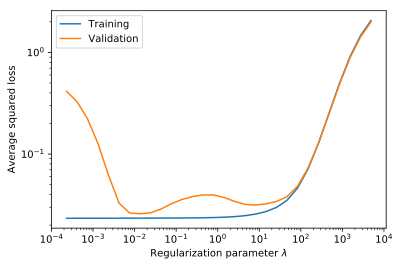

In [ ]:
plt.loglog(lam[45:75], err_train[45:75], lam[45:75], err_cv[45:75])
plt.legend(["Training", "Validation"])
plt.xlabel("Regularization parameter $\lambda$")
plt.ylabel("Average squared loss")

This plot suggests that regularization parameters between $10^{-2}$ and $10^1$ appear to work best for this problem (I would personally not put much stock in the middle bump between the two extremes, as this is likely an artificat of the particular cross validation set, and the whole range still suffers relatively low error.

## Other nonlinear features

Using polynomials served as as good illustration of the basic principles of nonlinear features, generalization, and regularization, but they are far from the only such type of feature used in practice (and indeed, polynomials are probably a bit less common in most cases than other feature classes.  We also only covered polynomials for one dimensional "raw" inputs, where it was easy to enumerate all possible polynomials.  In this section we'll cover another type of common nonlinear feature, radial basis functions, and illustrate how to create both polynomials and radial basis functions over multi-dimensional raw inputs.

For the purposes of this section, we're going to adopt a slightly more explicit notation, though in general we're going to use it _only_ for this section.  Specifically, whereas before we used $x^{(i)}$ to generally refer to the input features to the algorithm, here we're going to use $x^{(i)} \in \mathbb{R}^n$ (or often just $x \in \mathbb{R}^n$, if we don't need to index over a data set), to refer to just the "raw" input features: i.e., in the case of our peak demand prediction problem $x$ would just refer to the high temperature
\begin{equation}
x^{(i)} \in \mathbb{R}^1 = \left [ \; \mathrm{HighTemperature}^{(i)} \; \right ]
\end{equation}
The raw inputs need not always be one dimensional, of course, for instance we previously used the example of including both the temperature and a day of the week flag as features
\begin{equation}
x^{(i)} \in \mathbb{R}^2 = \left [ \begin{array}{c} \mathrm{HighTemperature}^{(i)} \\ \mathrm{IsWeekday}^{(i)} \end{array} \right ]
\end{equation}

But note that here we don't include any of the polynomial features directly in $x$; instead, $x$ only captures the tru underlying inputs to the algorithm, the elements that we are providing that are not derived from the other quantities (and note that that it also doesn't include the constant feature, for instance).  Instead, we'll define a _feature mapping_
\begin{equation}
\phi : \mathbb{R}^n \rightarrow \mathbb{R}^k
\end{equation}
to be a function that maps $n$-dimensional inputs to $k$ dimensional _features_.  Everything else remains the same, except that we now consider the hypothesis function that is linear in these feature vectors, i.e.,
\begin{equation}
h_{\theta}(x) = \theta^T \phi(x)
\end{equation}
parameterized by $\theta \in \mathbb{R}^k$.

For example, for a degree-3 polynomial (in one input variable), we can define $\phi : \mathbb{R} \rightarrow \mathbb{R}^4$ as
\begin{equation}
\phi(x) = \left [ \begin{array}{c} x^3 \\ x^2 \\ x \\ 1 \end{array} \right ]
\end{equation}
and similarly for larger degree
polynomials.  Hopefully it is clear that this is just a notational definition, but it is useful for begin a bit more precise about these nonlinear features.

## Radial basis functions

If I were to make a completely anecdotal estimate, I would guess that the most frequently used type of nonlinear feature in not the polynomial, but something called the _radial basis function_ (this is actually the case both for explicit features and for the kernel methods we'll talk about shortly), often abreviated as RBF.  Radial basis functions are similar to polynomials in that they are non-linear functions of the input data, but they are notably different in that they are generally _local_ features: the value of any particular feature is close to zero for most of the input space, but non-zero in a small region around a "center" parameter.  Let's start with the definition, and we can then provide some illustrations that hopefully make this more concrete.  To keep this simple to start, we're only going to consider radial basis functions of one-dimensional raw inputs, though we'll shortly expand this to cover the general $n$-dimensional case.  A radial basis function feature vector is defined as the following:
\begin{equation}
\phi : \mathbb{R} \rightarrow \mathbb{R}^k = \left [ \begin{array}{c} 
\exp \left(\frac{-(x - \mu^{(1)})^2}{2\sigma^2} \right) \\
\exp \left(\frac{-(x - \mu^{(2)})^2}{2\sigma^2} \right) \\
\vdots \\
\exp \left(\frac{-(x - \mu_{(k-1)})^2}{2\sigma^2} \right) \\
1
\end{array} \right ]
\end{equation}
where $\mu^{(1)},\ldots,\mu^{(k-1)} \in \mathbb{R}$ (called the means) and $\sigma \in \mathbb{R}$ (called the bandwidth) are the hyperparameters of this feature vector.  

Let's look at a single one of these terms $\phi_j(x)$ (this is the $j$th element of the feature vector, because remember $\phi(x)$ outputs a $k$-dimensional vector.
\begin{equation}
\phi_j(x) = \exp \left(\frac{-(x - \mu^{(j)})^2}{2\sigma^2} \right)
\end{equation}
If you're familiar with the Gaussian distribution, you may recognize this as looking similar to the density function of the Gaussian (though without the normalizeng constant).  One single dimension of this feature (for varying inputs $x$, and here assuming mean $\mu^{(j)} = 1.5$ and $\sigma = 0.4$) looks like the following:

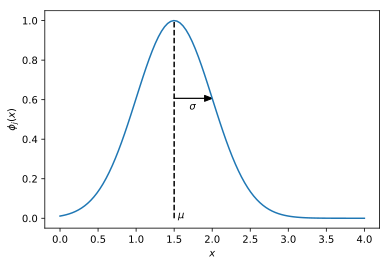

In [ ]:
x = np.linspace(0,4,100)
mu_j = 1.5
sigma = 0.5
plt.plot(x,np.exp(-(x-mu_j)**2 / (2*sigma**2)))
plt.plot([1.5,1.5], [0,1], 'k--')
plt.text(1.55, 0, r"$\mu$")
plt.arrow(1.5, np.exp(-0.5), 0.5-0.1, 0, head_width=0.03, head_length=0.1, fc='k')
plt.text(1.7, 0.55, r"$\sigma$")
plt.xlabel("$x$")
plt.ylabel(r"$\phi_j(x)$")

The feauture is largest (equal to one) when $x$ is equal to $\mu$, but falls of very rapidly as $x$ moves away from $\mu$ (proportional to the exponential of the negative squared difference, which will go effectively zero very quickly).  Those who are familiar with Gaussian densities will notice the familiar formula and bell-shaped curve, where about two thirds of the area under the curve lies within $\sigma$ of the center.  Note however, that despite superficial similarities, this is _not_ a Gaussian distribution: it is not scaled, and the maximum value for any specific feature is always 1.0 for $x = \mu_j$.  To emphasize this difference further, some definitions of RBFs define them just in terms of a different scaling parameter instead of the bandwidth
\begin{equation}
\phi_j(x) = \exp(-\gamma (x-\mu^{(j)})^2)
\end{equation}
which of course is equivalent to the above if we set $\gamma = 1/(2\sigma^2)$.  However, it's a bit more common to see the bandwidth parameter formulation, just because it _does_ let you use the general intuition about the size of a bell curve that many people have from using Gaussian distributions.

To get some intuition about how these RBFs work as features, consider a feature vector with $k=10$ (i.e., 9 RBF features plus a constant term), with $\mu^{(j)} = 0,0.5,1.0,\ldots,4.0$ and $\sigma=0.5$.  The set of all basis functions looks like the following.

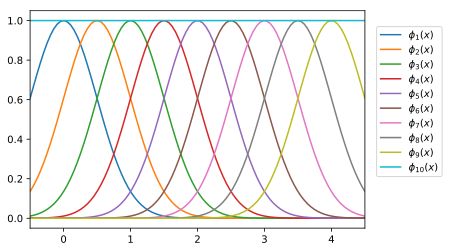

In [ ]:
x = np.linspace(-0.5,4.5,100)
mu = np.linspace(0,4,9)
sigma = 0.5
for mu_ in mu:
    plt.plot(x, np.exp(-(x-mu_)**2 / (2*sigma**2)))
plt.plot([-0.5,4.5], [1,1])
plt.xlim([-0.5,4.5])
plt.legend([r"$\phi_{" + str(j+1) + "}(x)$" for j in range(10)], bbox_to_anchor=(1.02,0.95))

The goal of nonlinear fitting with RBFs is to approximate the underlying function with a linear combination of these features.  By combining them in the proper manner, it is possible to approximate very general functions.

To see, this, let's go back again to the nonlinear version of the peak demand prediction problem.  We can construct a set of 10 dimensional RBFs spanning the minimum and maximum values of $x$.  For simplicity, we choose $\sigma$ to be equal to the distance between the means (this was done above, and seems reasonable, though we'll consider other ways of choosing $\sigma$ below).  Note also that there is no need to normalize the data, because the RBF features will always be scaled to be between zero and one (we could further normalize the generated features themselves, but this is typically not needed, as the features by definition will already be scaled to the range $[0,1]$).

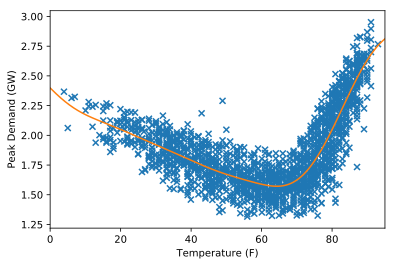

In [ ]:
def rbf_feat(x, mu, sig):
    return np.hstack([np.exp(-(x[:,None] - mu)**2/(2*sig**2)), np.ones((len(x),1))])

def plot_regression_rbf(theta, mu, sig):
    xt = np.linspace(0,95, 400)
    yt = rbf_feat(xt, mu, sig) @ theta
        
    plt.scatter(df["Temp"], df["Load"], marker="x")
    ylim = plt.ylim()
    plt.plot(xt, yt, 'C1')
    plt.xlabel("Temperature (F)")
    plt.ylabel("Peak Demand (GW)")
    plt.xlim([0,95])
    plt.ylim(ylim)
                  

def train_rbf(x, y, n_rbf):
    min_x, max_x = x.min(), x.max()
    sig = (max_x - min_x)/(n_rbf-1)
    mu = np.linspace(min_x, max_x, n_rbf-1)
    
    Phi = rbf_feat(x, mu, sig)
    theta = np.linalg.solve(Phi.T @ Phi, Phi.T @ y)
    return theta, mu, sig
    
x = df["Temp"].values
plot_regression_rbf(*train_rbf(x, y, 10))

### RBFs and overfitting
Although we will only describe it briefly, RBFs can exhiit the same overfitting tendencies as we saw in the the case of polynomial degrees.  For example, here is an 80 RBF fit to the data, using the same methodology as above, where we choose $\sigma$ to be the distance between centers.

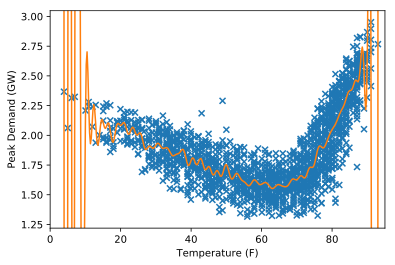

In [ ]:
plot_regression_rbf(*train_rbf(x, y, 80))

We can again see this overfittings looking at training and validation errors.

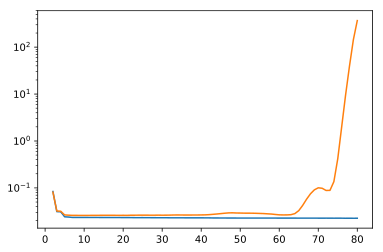

In [ ]:
x_train, y_train = df["Temp"].iloc[idx_train].values, df["Load"].iloc[idx_train].values
x_cv, y_cv = df["Temp"].iloc[idx_cv].values, df["Load"].iloc[idx_cv].values

err_train = []
err_cv = []
for i in range(2,81):
    theta, mu, sig = train_rbf(x_train, y_train, i)
    err_train.append(((rbf_feat(x_train, mu, sig) @ theta - y_train)**2).mean())
    err_cv.append(((rbf_feat(x_cv, mu, sig) @ theta - y_cv)**2).mean())

plt.semilogy(range(2,81), err_train, range(2,81), err_cv)

### Hyperparameters in RBFs
Unlike polynomials, where the only real hyperparameter relevant to the features themselves (not the regularization) is the degree of the polynomial, for RBF features there are a number of hyperparameter choices: the choice of centers themselves (and the number of centers as highlighted above), the bandwidth parameter $\sigma$, and the regularization parameter $\theta$.  It can be somewhat understand intuitively how we might trade off between all these different choices, and the good news is that there are some rules of thumb for choosing reasonable values for many of the hyperparameters without resorting to a grid search.  However, for the time being, we do want to briefly highlight the effect that the different hyperparameters have on the resulting performance.

**Effect of centers** We have already seen how the number of centers affects the fit of the data, so we will just briefly mention here that while the "obvious" choice for RBF centers on 1D data is to simply use an even grid over the input space, this doesn't work well for higher dimensions.  We will see more on this point shortly.

**Effect of regularization** Just like with polynomial features, we can add regularization to additionally smooth the function.  Unlike regularization for polynomial features, however, with a lot of narrow-peaked RBF functions, it is not trivial to fit the data with small weights.  This is precisely due to the local nature of the RBF features.  Because each features is only non-zero for a small part of the input space, we often cannot find a good fit to the data that has as very low weights: there is no equivalent to the "just choosing low degree terms" as we did for the polynomial, at least not if the bandwidth is chosen equal to the distance that the centers are apart (more on this shortly).  We can see that by looking at the fit for differe level of regularization with $k=80$.

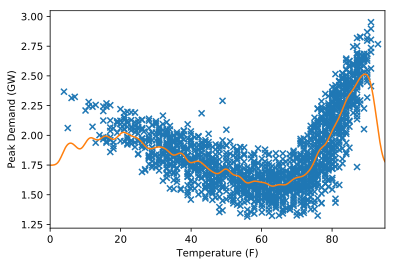

In [ ]:
def train_rbf_reg(x, y, n_rbf, lam):
    min_x, max_x = x.min(), x.max()
    sig = (max_x - min_x)/(n_rbf-1)
    mu = np.linspace(min_x, max_x, n_rbf-1)
    
    Phi = rbf_feat(x, mu, sig)
    theta = np.linalg.solve(Phi.T @ Phi + lam*np.eye(n_rbf), Phi.T @ y)
    return theta, mu, sig

plot_regression_rbf(*train_rbf_reg(x, y, 80, 10.0))

Unlike the regularized polynomial, despite the fact that we are alredy starting to miss some of the overall shape of the data, the "nonsmooth" fit persists.   However, despite the somewhat visually unintuitive nature of the fit, from an actual overfitting standpoint, the cross validation error (at its minimum) is only slightly higer than for the setting with no regularzation and fewer centers.

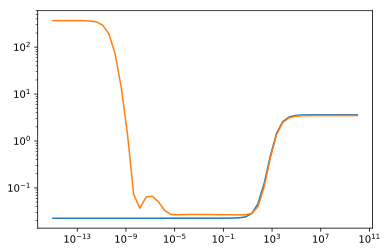

In [ ]:
err_train = []
err_cv = []
lam = np.logspace(-15,10)
for l in lam:
    theta, mu, sig = train_rbf_reg(x_train, y_train, 80, l)
    err_train.append(((rbf_feat(x_train, mu, sig) @ theta - y_train)**2).mean())
    err_cv.append(((rbf_feat(x_cv, mu, sig) @ theta - y_cv)**2).mean())

plt.loglog(lam, err_train, lam, err_cv)

**Effect of bandwidth parameter** The effect of the bandwidth parameter, $\sigma$, can be a bit somewhat less obvious.  At a high-level, though, the intuition that is important here is that larger $\sigma$ leads to _smoother_ features functions, which in turns leads to smoother final functions.  For example, let's consider our previous setting of 10 total features, but double the bandwidth from 0.5 to 1.0.

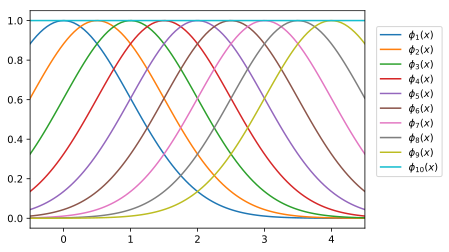

In [ ]:
x = np.linspace(-0.5,4.5,100)
mu = np.linspace(0,4,9)
sigma = 1.0
for mu_ in mu:
    plt.plot(x, np.exp(-(x-mu_)**2 / (2*sigma**2)))
plt.plot([-0.5,4.5], [1,1])
plt.xlim([-0.5,4.5])
plt.legend([r"$\phi_{" + str(j+1) + "}(x)$" for j in range(10)], bbox_to_anchor=(1.02,0.95))

A linear combination of these functions will necessarily be smoother.  Thus, if we have fixed the number of means, but have a larger $\sigma$ (instead of just always setting $\sigma$ to be equal to the distance between means), we are also enforcing a _simpler_ model (i.e., larger bandwidth acts the same as larger regularization, but for a different reason).  Let's see this in our example from before, where we still have 80 RBF features, but we increase the bandwidth by some factor (here we also add a small amount of regularization, as it prevents numerical issues that occur with very high bandwidths).

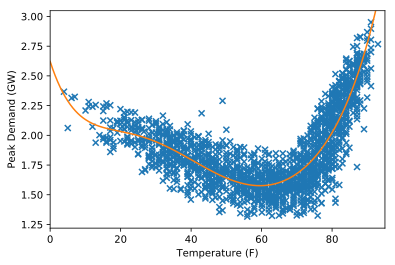

In [ ]:
def train_rbf_sig(x, y, n_rbf, sig_factor):
    min_x, max_x = x.min(), x.max()
    sig = sig_factor * (max_x - min_x)/(n_rbf-1)
    mu = np.linspace(min_x, max_x, n_rbf-1)
    
    Phi = rbf_feat(x, mu, sig)
    theta = np.linalg.solve(Phi.T @ Phi + 1e-12*np.eye(n_rbf), Phi.T @ y)
    return theta, mu, sig

x = df["Temp"].values
plot_regression_rbf(*train_rbf_sig(x_train, y_train, 80, 100.0))

Compare this again to our fit for the original choice of $\sigma$.

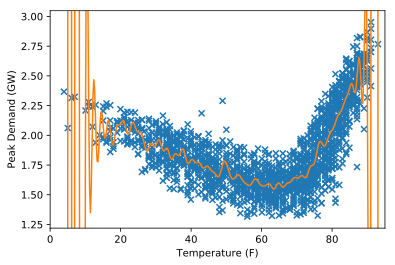

In [ ]:
plot_regression_rbf(*train_rbf_sig(x_train, y_train, 80, 1.0))

And finally the cross-validation figure showing the performance relative to this parameter.

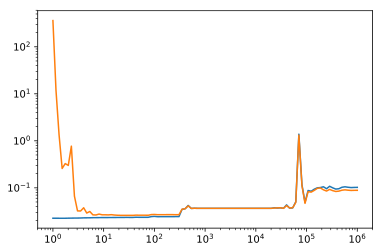

In [ ]:
err_train = []
err_cv = []
sigs = np.logspace(0,6,100)
for s in sigs:
    theta, mu, sig = train_rbf_sig(x_train, y_train, 80, s)
    err_train.append(((rbf_feat(x_train, mu, sig) @ theta - y_train)**2).mean())
    err_cv.append(((rbf_feat(x_cv, mu, sig) @ theta - y_cv)**2).mean())

plt.loglog(sigs, err_train, sigs, err_cv)

Again, as expected, there is a range in the intermediate values of $\sigma$ (here a scaling of about 10-100 times the distance between points), where the resulting models perform best.

The best way to gain some degree of intuition and familiarity with these models is to play around to see what sort of results come out, so I would encourage everyone to download the notebook and try out different settings for the RBF hyperparameters to get a feel for how they perform.  However, choosing the number of RBFs (even assuming an even grid), the bandwidth parameter $\sigma$, _and_ the regularization parameter all together can be a challenging task, and so shortly we will highlight a few of the common tricks to choose these hyperparameters.

## Nonlinear features in higher dimensions

Thus far, we have considered nonlinear features only in the case where the raw input was one-dimensional.  This is useful to convey the basic principles of the method, but in most cases we can have multiple "raw" inputs in our data.  For example, the cancer prediction task we focused on in our classification example was had 30 underlying dimensions, and even in our simplified setting there (which was largely for visual purposes) we considered the case of two separate raw inputs.  Thus, it is important to generalize our features beyond one dimensional inputs to their full generality.  We will present the main ideas and code here, and then illustrate these methods in the next section in the context of classification.

### Multidimensional polynomials

To illustrate simple polynomials in higher dimensions, let's consier the case of a two-dimensional raw input $x \in \mathbb{R}^2$, and let's consider all polynomials terms of degree up to $d=3$.  We can just enumeate all of these easily enough:
\begin{equation}
\phi(x) = \left [ \begin{array}{c}
1 \\
x_1 \\
x_1^2 \\
x_1^3 \\
x_2 \\
x_2^2 \\
x_2^3 \\
x_1 x_2 \\
x_1 x_2^2 \\
x_1^2 x_2
\end{array} \right ].
\end{equation}
The important parts to take note of here are the crossterms: $x_1 x_2$, $x_1 x_2^2$, $x_1^2 x_2$.  But what about generally when there are $n$ features and we want to compute all degree $d$ polynomials?  In this case it becomes a little bit less obvious how we generalize this to compute all possible features up to degree $d$.

Formally, we can define the set of all features we would like to generate as
\begin{equation}
\phi(x) = \left \{ \prod_{i=1}^n x_i^{b_i} : b_i \in \mathbb{N}, \sum_{i=1}^n b_i \leq d \right \}
\end{equation}
i.e., the set of all products of all $n$ $x_i$ terms, each raised to some non-negative integer power $b_i$, such that the sum of all the $b_i$'s is less than $d$.  But this isn't particularly helpful for actually generating these in code.  In general, the way to generate all these combinations manually is by some recursive routine, but fortunately Python has the necessary routines included in the `itertools` module.  Specifically, the `combinations_with_replacement()` function generates all combinations of $d$ elements from a list or vector (allowing repetitions of a single item in the list.  For example, consider the following code.

In [ ]:
from itertools import combinations_with_replacement
x = np.array(["x1","x2","x3"]) # just an example
list(combinations_with_replacement(x,3))

[('x1', 'x1', 'x1'),
 ('x1', 'x1', 'x2'),
 ('x1', 'x1', 'x3'),
 ('x1', 'x2', 'x2'),
 ('x1', 'x2', 'x3'),
 ('x1', 'x3', 'x3'),
 ('x2', 'x2', 'x2'),
 ('x2', 'x2', 'x3'),
 ('x2', 'x3', 'x3'),
 ('x3', 'x3', 'x3')]

If we then take the product of these terms, it would give us all the polynomials of degree _exactly_ $d$.  If we want to get the terms with degree _up to_ $d$, then we can just add an additional "1" to our list, since selecting this term would effectively decrease the number of other terms we take.

In [ ]:
from itertools import combinations_with_replacement
x = np.array(["x1","x2","x3","1"]) # just an example
list(combinations_with_replacement(x,3))

[('x1', 'x1', 'x1'),
 ('x1', 'x1', 'x2'),
 ('x1', 'x1', 'x3'),
 ('x1', 'x1', '1'),
 ('x1', 'x2', 'x2'),
 ('x1', 'x2', 'x3'),
 ('x1', 'x2', '1'),
 ('x1', 'x3', 'x3'),
 ('x1', 'x3', '1'),
 ('x1', '1', '1'),
 ('x2', 'x2', 'x2'),
 ('x2', 'x2', 'x3'),
 ('x2', 'x2', '1'),
 ('x2', 'x3', 'x3'),
 ('x2', 'x3', '1'),
 ('x2', '1', '1'),
 ('x3', 'x3', 'x3'),
 ('x3', 'x3', '1'),
 ('x3', '1', '1'),
 ('1', '1', '1')]

More concretely, for a matrix $X \in \mathbb{R}^{m \times n}$ consisting of all the raw inputs as rows in the vector, we can compute the matrix of all polynomial products as follows.

In [ ]:
def poly_feat(X,d):
    X_ = np.hstack([X, np.ones((X.shape[0],1))]).T # add ones
    return np.array([np.array(a).prod(axis=0) for a in combinations_with_replacement(X_,d)]).T

X = np.random.randn(2,3)
poly(X,2)

array([[ 0.07579395, -0.06574806, -0.09650191, -0.27530702,  0.05703368,
         0.08371134,  0.23881724,  0.12286756,  0.35052469,  1.        ],
       [ 0.41816434, -0.46225432,  0.04728858, -0.64665628,  0.510993  ,
        -0.05227454,  0.71483774,  0.00534768, -0.07312784,  1.        ]])

**Number of polynomial features** How many polynomial features will we generate by this procedure?  Essentially, as argued above, for $n$ raw features, we are selecting $d$ items with replacement from $n+1$ items (the raw features plus the one term).  This is known as a _multisubset_, and it can be shown that the total number of such selections are ${n+d \choose d}$.  The proof is simple, but not entirely trivial either, and can be seen [here](https://en.wikipedia.org/wiki/Stars_and_bars_(combinatorics%29).


### Multidimensional RBFs

What about RBFs with multiple input dimensions?  In this case the formula ends up being quite similar to the version before, just replacing the squared different between input $x$ and mean $\mu^{(j)}$ with the squared Euclidean distance (both $x$ and $\mu^{(j)}$ here are now vectors in $\mathbb{R}^n$.  THat is, the multidimensional RBFs i just defined as
\begin{equation}
\phi(x) = \left \{ \exp\left(\frac{ - \|x - \mu^{(j)}\|_2^2}{2 \sigma^2}\right) : i=1,\ldots,k-1 \right \} \cup \{1\}
\end{equation}

There are, however, some important difference between one-dimensional and multidimensional RBFs.  For one-dimensional RBFs, we did not need to worry about normalizing the data, because we could always choose means and bandwidths in the original units of the input data.  For the multidimensional case, however, the situation is quite different.  If one dimension has much larger scaling than the other, the distances can be dominated by the larger dimension.  Thus, it is important to scale the data to have rougly the same scale along each dimension (or equivalently, use different bandwidths over the different dimensions, but we'll just accomplish this by scaling the data).

The second important difference is in the choice of centers $\mu^{(j)}$.  In one dimension, it make sense to just evently space the centers over the entire range of the data.  In two dimensions, in order to have the same representational power, we need to place the centers in a grid over the 2D space, as in the figure below (here assuming the data has been normalized to lie in $[0,1]^2$).  In this case we show all 25 center points (5 divisions along each dimension), along with the level sets of two of the basis functions (showing all 25 basis functions leads to a fairly uninterpretable picture).

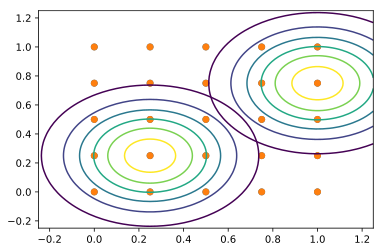

In [ ]:
XY = np.meshgrid(np.linspace(0,1,5), np.linspace(0,1,5))
mu = np.array([XY[0].ravel(), XY[1].ravel()]).T
plt.scatter(mu[:,0], mu[:,1])

XX,YY = np.meshgrid(np.linspace(-0.25,1.25,100), np.linspace(-0.25,1.25,100))
sig = 0.25
for mu_ in [mu[6], mu[19]]:
    ZZ = np.exp(-((XX-mu_[0])**2 + (YY-mu_[1])**2)/(2*sig**2))
    plt.contour(XX,YY,ZZ)
plt.scatter(mu[:,0], mu[:,1])
#plt.legend(["Centers", "Contours of one RBF"])

**Efficient computation** How do we efficiently compute the set of all RBFs in multiple dimensions?  The key here is finding a way to enumerate all squared differences between the rows in $X$ and all the centers $\mu^{(j)}$.  We could easily do this with a for loop, but it's actually much more efficient if we use matrix operations for this computation.  Specifically, consider computing the squared Eucliean distance between a data point $x^{(i)}$ and center $\mu^{(j)}$.  Note that
\begin{equation}
\|x^{(i)} - \mu^{(j)}\|_2^2 = (x^{(i)} - \mu^{(j)})^T(x^{(i)} - \mu^{(j)}) = \|x^{(i)}\|_2^2 + \|\mu^{(j)}\|_2^2 - 2 {x^{(i)}}^T \mu^{(j)}
\end{equation}
The first two terms can be computed just once for all $x^{(i)}$ and $\mu^{(j)}$, and the third term is just the $i,j$ element of a matrix product $X M^T$ where $M \in \mathbb{R}^{k-1 \times n}$ is a matrix that constains all the $\mu^{(j)}$ terms as its rows.

Thus, we can actually compute all squared differences in a single line of Python code, using a combination of broadcasting an matrix operations.

In [ ]:
def sqdist(X,M):
    return (X**2).sum(axis=1)[:,None] + (M**2).sum(axis=1) - 2*X @ M.T

X = np.random.randn(10,3)
M = np.random.randn(4,3)
D = sqdist(X,M)

# illustrate that the distance matrix gives correct distances
print(D[1,2], np.linalg.norm(X[1] - M[2])**2)

0.862929636357 0.862929636357


Given this, we can easily create a routine that creates all RBF centers.

In [ ]:
def rbf_feat(X, mu, sig):
    return np.exp(-sqdist(X,mu) / (2*sig**2))

**Size of RBF features**  Just as with polynomials, there is an obvious scaling issue with RBFs in multiple dimensions.  In order to have a complete grid of points over $n$ underlying dimenions, with $d$ centers along each dimension, we need $d^n$ total centers.  Thus, placing RBFs is an explicit grid over the entire range of the data is not feasible for more then 3-4 dimensions at most.

### Practical polynomials and RBFs

Due to the sheer number of polynomials and RBF features generated by the "naive" approaces above, typically generating all possible polynomials and all possible RBFs is not feasible for most problems.  Thus, in order to feasibly apply nonlinear modeling, using both polynomials and RBFs as examples, we need some amount of specialization beyond just forming the "naive" complete feature vectors.

**Practical polynomials** The general rule of making polynomials practical, somewhat anti-climactically, is just not to try to form very large degree polynomials, or to do so when the dimensionality of the raw inputs is small.  Note that ${n + d \choose d}$ is only large if both $n$ and $d$ are large, so the general rule of thumb is that for large $n$, you'll need to limit yourself to small $d$ (often even just quadratic features), and if you want large $d$, then you'll have to restrict yourself to a small number of features.

There are also a few other tricks that are relevant, though they typically require some understanding of the data.  For example, for features $x_j$ that are binary, there is no point to ever forming higher order polynomials of this term $x_j^2$, because $x_j = x_j^2$ for $x_j \in \{0,1\}$.  Thus, while product of binary input and _other_ inputs are relevant and can lead to additional representational power, multiplying a binary input with itself is never useful.  It's also common to only multiply some _subset_ of the terms together.  So if you believe, for instance, that temperature will affect power consumption differently on weekdays and weekends, it may make sense to include the term
\begin{equation}
\mathrm{Temperature}^2 \cdot \mathrm{IsWeekday}
\end{equation}
but maybe you have no reason to include the term
\begin{equation}
\mathrm{Temperature}^2 \cdot \mathrm{Humidity}
\end{equation}
and the product of humidity and temperature has no obvious relevance to the prediction problem.  If data has an obvious spatial relevance for example (this is common in images), then maybe we want to form quadratic terms for _nearby_ pixels, but not between all pixels in the image (this can be generalized to inputs that have some form of graph structure, too).

Note that as mentioned, however, all these approaches typically do require some insight into the problem, and are not exactly a "generic" approach that you can apply to any new data set.

**Practical RBFs** There are a few tricks for RBF features, however, that _are_ fairly generic.  In total these make RBFs a very nice "first attempt" at nonlinear features, before you attempt a more complex algorithm like neural networks.

The first crucial point for considering RBFs on higher dimensional inputs is that we do _not_ want to attempt to cover the entire input space with a grid of RBF centers.  Although this is in some sense an obvious strategy, the reality is that if you have high dimensional input data, it almost certainly does _not_ cover the entire input space to begin with:for the same reason that it is difficult to place centers that cover the space it is difficult for inputs to cover this whole space, and instead what is most likely happening is that our input data lies on a relatively small manifold in the input space.  Thus, if you place centers in a grid over the entire space, you will be wasting a lot representational power with centers that don't lie very close to any data point.

Fortunately, there is a very easy solution here: _choose your centers randomly from the data points themselves_.  There are actually a few tricks to making this work slightly better: you probably want to pick centers that are spread out from each other, whereas just randomly picking points may not achieve this.  To fix this, you can pick points sequentially with a probabily that decreased based upon how close they are to an existing center; or even more formally, you can do this and then further adjust the points using the k-means algorithm.  But these are just slightly more sophisticated version of the same basic principle, that you want to pick your RBF centers based upon the data itself, and not just based upon the dimension of the data.

Second, there is a handy trick for choosing the bandwidth parameter $\sigma$.  Instead of relying of cross-validation to choose $\sigma$, simply choose it as follows:
\begin{equation}
\sigma = \mathrm{median}(\{\|x^{(i)} - \mu^{(j)}\|_2, i=1,\ldots,m, j=1,ldots,k-1\}).
\end{equation}
In other words, we set $\sigma$ to be equal to the median of the distance between data points and the RBF centers.  The intuition for this trick is the following: we "typically" would like the term inside the exponent of the RBF feature to be on the order of some constant (if they are too small the RBF features all equal one, and we lose the ability to differentiate between points; alternatively if they are too large then the RBF features go to and we don't get any information for many of the points).  Recall that the inner term is
\begin{equation}
\phi_j(x) = \exp\left(\frac{ - \|x - \mu^{(j)}\|_2^2}{2 \sigma^2}\right).
\end{equation}
Choosing $\sigma^2$ to be approximately $\|x - \mu^{(j)}\|_2^2$ makes the inner term equal 1/2.  Of course we can't make it 1/2 for _all_ points, but choosing $\sigma$ to be the median value of this quantity means that a lot of the points will be "close" to this constant value.  [Note: the class slides have a slighty different formulation, and use a median between the centers themselves, but if the centers are chosen to be random points this will be a similar quantity, of course].  This "median trick" doesn't appear much in the literature, but it's fairly common knowledge to those who work with RBFs (though usually stated for the case of kernels, which we will discuss shortly).  [Here](https://arxiv.org/abs/1707.07269), for instance, is a recent paper that has some discussion about the origins of this trick (I'm not endorsing or critizing the paper, as I haven't read through the actual contribution, but the background highlights some discussion of the median trick).

With both these approximations, it is fairly straightforward to apply RBF features to general data sets, and not have any more parameters to select via cross-validation than in traditional regression (namely, the choice of the regularization parameter).

## Kernels

One last topic bears mentioning before we show some examples of higher-dimensional nonlinear features (which we will do in conjunction with our discussion on classification): using kernels for nonlinear features.  Although they have recently fallen out of favor a bit to deep learning methods, kernels remain a primary tool in machine learning that is worth knowing about.  Especially for relatively small data sets, they often represent of the "quickest and easiest" approaches to nonlinear classification and regression.  Our coverage here is necessarily going to be very brief, and not do any sort of justice to the full topic of kernels, but hopefully it covers enough to the point where you can understand the basics of how these methods work at a high level.

At their core, kernels are a method for working with high dimensional feature vectors _without explicitly forming_ the feature vectors themselves.  This may seem like magic at first, but the theory is surprisingly simple at an informal level.

### Representation of $\theta$

The starting point for our discussion on kernels will be the following fact. For machine learning model with a linear (in features) hypothesis function $h_\theta(x) = \theta^T \phi(x)$, if we train the classifier on some data set $(x^{(1)}, y^{(1)}),\ldots,(x^{(m)}, y^{(m)})$, then the optimal solution $\theta^\star$ will always be some linear combination of the features themselves
\begin{equation}
\theta^\star = \sum_{i=1}^m \alpha_i \phi(x^{(i)})
\end{equation}
where $\alpha_i in \mathbb{R}$, $i=1,\ldots,m$ are some set of coefficients on the different $\phi(x^{(i)})$ terms.  
This can be seen by looking at the actual gradient descent updates we perform as we train our algorithm.  For instance, in the case of classification, where our loss function is given by 
\begin{equation}
\ell(h_\theta(x),y) = f(y \cdot \theta^T \phi(x))
\end{equation}
then at each iteration we perform the update
\begin{equation}
\begin{split}
\theta & := \theta - \sum_{i=1}^m f'(y^{(i)} \cdot \theta^T \phi(x)) y^{(i)} \phi(x^{(i)}) \\
& = \theta - \sum_{i=1}^m \beta_i \phi(x^{(i)})
\end{split}
\end{equation}
setting $\beta_i$ to just be the relevant terms from the previous expression.  It's also possible to prove directly from properties of optimization that the optimal $\theta$ must take on this form, but we won't worry about this for now.  For our purposes, it is enough to simply accept that $\theta$ must take this form.

Given this form of $\theta$, our hypothesis function would then take the form
\begin{equation}
h_\alpha(x) = \sum_{i=1}^m \alpha_i \phi(x^{(i)})^T \phi(x)
\end{equation}
where we use the notation $h_\alpha(x)$ to emphasize that the parameters $\alpha \in \mathbb{R}^m$ are now the parameters of our hypothesis function.  The key point to emphasize here is that the hypothesis function in this form is expressible only via _inner products_ between the feature vectors of different points
\begin{equation}
\phi(x^{(i)})^T \phi(x) \equiv \sum_{j=1}^k \phi_j(x^{(i)}) \phi_j(x).
\end{equation}

### Efficient computation of inner products

This now leads us to key idea of kernels, that in many cases we can compute the inner product between two high-dimensional feature vectors _without ever forming the vectors themselves_.  To see this, let's consider a simple case of two-dimensional inputs $x \in \mathbb{R}^2$ and $z \in \mathbb{R}^2$ ($z$ here denotes another input like $x$, we're just using a separate letter to make the following notation and math a bit simpler).  Let's say that we are considering polynomial feature vectors of degree $d=2$
\begin{equation}
\phi(x) = \left [ \begin{array}{c} x_1^2 \\ \sqrt{2} x_1 x_2 \\ x_2^2 \\ \sqrt{2} x_1 \\ \sqrt{2} x_2 \\ 1 \end{array} \right ]
\end{equation}
and similarly for $\phi(z)$.  Note that this is exactly the same as the degree-2 polynomial over two features that we saw previously except for the additional $\sqrt{2}$ terms (which can always just be factored into the parameter vector $\theta$).  But now consider the inner product between two of these feature vectors $\phi(x)^T \phi(z)$, which is given by
\begin{equation}
\begin{split}
\phi(x)^T \phi(z) & = x_1^2 z_1^2 + 2 x_1 x_2 z_1 z_2 + x_2^2 z_2^2 + 2 x_1 z_1 + 2 x_2 z_2 + 1 \\
& = (x_1 z_1 + x_2 z_2)^2 + 2(x_1 z_1 + x_2 z_2) + 1 \\
& = (x^T z)^2 + 2(x^T z) + 1 \\
& = (x^T z + 1)^2.
\end{split}
\end{equation}
This equation looks simple enough, but it is saying something rather profound: to compute the inner product of the 6-dimensional feature vectors $\phi(x)$ and $\phi(z)$ _we don't need to actually form these feature vectors_.  Instead, we just need to form the inner product of the two dimensional inputs $x^Tz$, add one, and square the result.  We have computed the _exact_ same term as the full inner product, without ever forming the features.

It turns out this is a very general property.  Given any two inputs $x,z \in \mathbb{R}^n$, and letting $\phi : \mathbb{R}^n \rightarrow \mathbb{R}^{n+d \choose d}$ be a feature vector of all polynomials up to degree $d$ (with a certain scaling that we won't explicitly mention here), then
\begin{equation}
\phi(x)^T \phi(z) = (x^T z + 1)^d.
\end{equation}
In other words, we can compute the _exact_ inner products in between the ${n+d \choose d}$-dimensional feature vectors (which are much too large to store explicitly), in time only $O(n)$ (the time it takes to compute $x^T z$ between the original inputs).

We call these inner products (computed efficient), a _kernel function_, a function $K : \mathbb{R}^n \times \mathbb{R}^n \rightarrow \mathbb{R}$ such that
\begin{equation}
K(x,z) = \phi(x)^T \phi(z),
\end{equation}
and the above example is such an instance, the so-called _polynomial kernel_
\begin{equation}
K(x,z) = (x^T z + 1)^d.
\end{equation}

In fact, we can get even crazier.  Although we won't prove it here (or even really give an example the way we did above), it turns out that the _RBF kernel_, defined as
\begin{equation}
K(x,z) = \exp\left(\frac{-\|x - z\|_2^2}{2 \sigma^2} \right )
\end{equation}
(note the obvious similarly to the RBF basis) corresponds to the inner product between two _infinite dimensional_ feature vectors $\phi(x)^T \phi(z)$ where $\phi(x)$ corresponds to an RBF feature with a center _at every point in space_.

### Building kernel ML algorithms

Using kernels in an ML algorithm ultimately just requires that we replace the previous hypothesis function $h_\theta(x) = \theta^T \phi(x)$ with the hypothesis function $h_\alpha(x) = \sum_{i=1} \alpha_i K(x^{(i)},x)$ (writing it in terms of the kernel function this time).  But at a high level, this is just another kind of hypothesis function that is still _linear_ in the parameters ($\alpha$), and so we can use all the same methods we used previously to find the parameters $\alpha$ that minimize the loss.

Let's quickly see how this works, for instance, in the case of (regularized) least squares, a setting that is typically referred to as _kernel ridge regression_.  To start, note that the squared Euclidean norm of the parameters $\|\theta\|_2^2$ can also be written in terms of the kernel hypothesis
\begin{equation}
\begin{split}
\|\theta\|_2 = \theta^T \theta \\
& = \left(\sum_{i=1}^m \alpha_i \phi(x^{(i)})^T \right ) \left( \sum_{j=1}^m \alpha_j \phi(x^{(j)}) \right ) \\
& = \sum_{i=1}^m \sum_{j=1}^m \alpha_i \alpha_j K(x^{(i)}, x^{(j)}) \\
& = \alpha^T K \alpha
\end{split}
\end{equation}
where $K \in \mathbb{R}^{m \times m}$ is a matrix of all kernel functions between all points in the training data, $K_{ij} = K(x^{(i)}, x^{(j)})$.  Thus, our regularized least-squares loss function is given by
\begin{equation}
\begin{split}
& \minimize_\alpha \;\; \frac{1}{m} \sum_{i=1}^m \left (\sum_{j=1}^m \alpha_j K(x^{(j)}, x^{(i)}) - y^{(i)} \right )^2 + \lambda \alpha^T K \alpha \\
\Longleftrightarrow & \minimize_\alpha \;\; \frac{1}{m} \|K \alpha - y\|_2^2 + \lambda \alpha^T K \alpha
\end{split}
\end{equation}
where this equivalence following by noting that the $i$th element of the vector $K \alpha - y$ is simply the term $\sum_{j=1}^m \alpha_j K(x^{(j)}, x^{(i)}) - y^{(i)}$, so we can replace the sum over the vector elements squared with the squared Euclidean norm of the vector.

Taking the gradient of this term (we're going to go through this quickly, but you can derive all the terms using the same methods as we did for least squares) gives
\begin{equation}
\nabla_\alpha \left(\frac{1}{m} \|K \alpha - y\|_2^2 + \lambda \alpha^T K \alpha \right ) = \frac{2}{m} K(K\alpha - y) + 2\lambda K \alpha
\end{equation}
and setting it equal to zero gives
\begin{equation}
\begin{split}
& 2 K K \alpha + 2\lambda m K \alpha =  2 K y \\ 
\Longrightarrow \;\; & (K + \lambda m I)\alpha = y \\
\Longrightarrow \;\; & \alpha = (K + \tilde{\lambda} I)^{-1} y
\end{split}
\end{equation}
where for simplicity we fold the $m$ term into $\tilde{\lambda}$.

Let's very briefly see what this looks like for our peak demand prediction example (note that this is not a great use case for kernels, since for one-dimensional inputs the explicit feature representation is more efficient, so we are just using it for illustration purposes).  Let's first consider a polynomial kernel.

(1.2190848495584987, 3.0484121504415009)

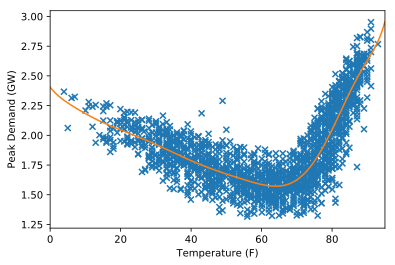

In [ ]:
def poly_kernel(X, Z, d):
    return (X @ Z.T + 1)**d

x = df["Temp"].values
min_x, max_x = x.min(), x.max()

X = np.array([2*(x - min_x)/(max_x - min_x) - 1]).T
y = df["Load"].values
lam = 1e-6
K = poly_kernel(X, X, 10)
alpha = np.linalg.solve(K + lam*np.eye(X.shape[0]), y)

xt = np.linspace(0,95,200)
Xt = np.array([2*(xt - min_x)/(max_x - min_x) - 1]).T
yt = poly_kernel(Xt, X, 10) @ alpha

plt.scatter(df["Temp"], df["Load"], marker="x")
ylim = plt.ylim()
plt.plot(xt, yt, 'C1')
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")
plt.xlim([0,95])
plt.ylim(ylim)

As expected, this performs the same as the degree 10 polynomial (with some amount of regularization).  But nowhere idd we actually form the degree-10 polynomial features.  Now let's try with the RBF kernel, using the same median trick for the bandwidth parameter.

(1.2190848495584987, 3.0484121504415009)

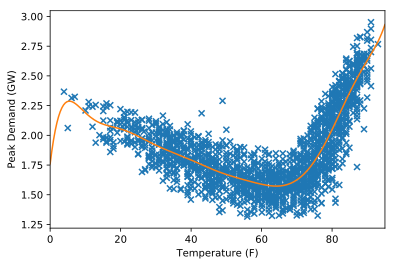

In [ ]:
D = sqdist(X,X)
sig = np.median(np.sqrt(D))
K = np.exp(-D/(2*sig**2))
alpha = np.linalg.solve(K + lam*np.eye(X.shape[0]), y)
yt = np.exp(-sqdist(Xt,X)/(2*sig**2)) @ alpha

plt.scatter(df["Temp"], df["Load"], marker="x")
ylim = plt.ylim()
plt.plot(xt, yt, 'C1')
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")
plt.xlim([0,95])
plt.ylim(ylim)

### Caveats of kernels

So if kernels let us use these high dimensional feature vectors without ever forming the feature matrix, why would we ever do anything else.  The answer lies in the fact that kernel methods are what are called _non-parameteric_ methods.  This is a somewhat poorly chosen name, because it doesn't mean that the method had no parameters (the $\alpha$'s are of course the parameters), but instead it means that the number of parameters grows with the number of points in the training set (recall that there is one $\alpha_i$ for each example).  Another big downside is that with traditional linear models, once the model is trained we could "throw out" the training data: the trained feature vector $\theta$ is all that is needed to make new predictions.  With kernels methods, we have to "keep around" the entire training data, because we need it to compute the kernel functions for some new example $x$, $K(x^{(i)},x)$.

This typically causes the run time of kernel methods to grow more than linearly with the number of training examples.  As we saw in the previous example, for kernel ridge regression, solving for $\alpha$ involved inverting the $m \times m$ matrix $K + \lambda I$, an operation that takes $O(m^3)$ time.  And even if we don't require exact solutions as in kernel ridge regression, just forming the gradient of a loss function with a kernel hypothesis typically takes times $O(m^2n)$ ($n$ to compute a single kernel evaluation, $m$ to compute the hypothesis on a single example, and $m$ again to sum over all examples).  When data sets are large, this is typically _far_ too costly to be tractable.  In response, a lot of work has been done to make kernel methods scale better to large data sets.  Yet, although we won't cover this at all, I'll just say that somewhat ironically, these efforts often a look a lot like a return to explicitly constructing features.

In summary, kernels are an extremely powerful method, but at the current time probably best suited to medium-sized data sets, maybe up to ten thousand training points or so.  Much beyond this and exactly kernel methods start to become too costly.

## Nonlinear classification

We'll end these notes with a discussion of classification with nonlinear features.  Just like with classification as a whole, the nice this about our algorithmic framework is that now that we have defined the general notation and frameworks for nonlinear features (both explicit features and implicit features with kernels), the application to the classification setting is just a manner of plugging in the relevant features into our classification algorithms.  Here we won't bother with implementing the algorithms again manually: this was done in the previous lecture notes on classification, so we won't highlight that point again.  Instead, we'll use the scikit learn implementations of the support vector machine with with explicit nonlinear features or with kernels, to visualize the kind of decision functions that result from the inclusion of nonlinear features in classification.

Let's begin by considering again our example of the breast cancer cell classification task, loading the data and running a linear SVM on the two-feature reduced example.

In [ ]:
import numpy as np
import sklearn.datasets
dat = sklearn.datasets.load_breast_cancer()

ix = np.where(dat["feature_names"] == "mean area")[0][0]
iy = np.where(dat["feature_names"] == "mean concave points")[0][0]

X = np.asarray([dat["data"][:,ix], dat["data"][:,iy]]).T
y = (1.*(dat["target"]==np.where(dat["target_names"] == "malignant")[0][0]) +
     -1.*(dat["target"]==np.where(dat["target_names"] == "benign")[0][0]))

In [ ]:
def plot_classification_sklearn(model, norm, feat):
    x_range = [0,2600]
    y_range = [0, 0.21]

    # plot classifcation regions
    grid=200
    xx,yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid),
                        np.linspace(y_range[0], y_range[1], grid))
    X_ = np.array([np.ravel(xx), np.ravel(yy)]).T
    zz = model.decision_function(feat(norm.transform(X_))).reshape(grid,grid)
    cs = plt.contourf(xx,yy,zz, zz,levels=[-float("inf"),0,float("inf")],alpha=0.2,colors=["b","r"])
    plt.contour(cs, colors='k')

    s1 = plt.scatter(dat["data"][:,ix][dat["target"]==1], dat["data"][:,iy][dat["target"]==1], marker='x', color='C0')
    s2 = plt.scatter(dat["data"][:,ix][dat["target"]==0], dat["data"][:,iy][dat["target"]==0], marker='+', color='C3')
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend([s1,s2], ['Benign', 'Malignant'])

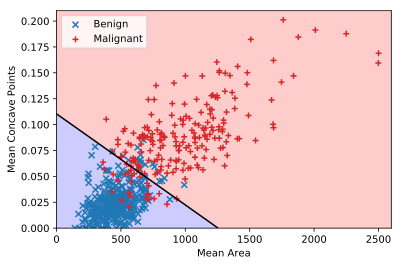

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

norm = MinMaxScaler(feature_range=(-1,1))
model = SVC(kernel='linear', C = 100.0)
model.fit(norm.fit_transform(X), y)
plot_classification_sklearn(model, norm, lambda x : x)

Now let's consider fitting the SVM to explicit polynomial features, first with degree 2.

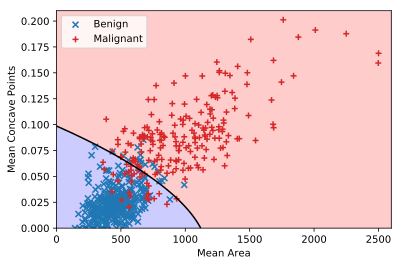

In [ ]:
Phi = poly_feat(norm.fit_transform(X), 2)
model.fit(Phi, y)
plot_classification_sklearn(model, norm, lambda X : poly_feat(X, 2))

We can see that the decision boundary now is nonlinear (in this case, it is quadratic).  We can continue fitting higher order polynomials.

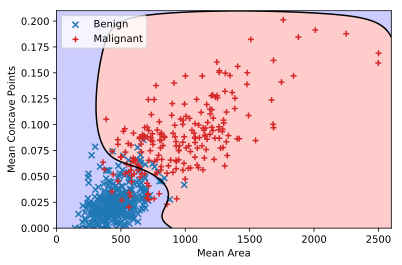

In [ ]:
Phi = poly_feat(norm.fit_transform(X), 10)
model.fit(Phi, y)
plot_classification_sklearn(model, norm, lambda X : poly_feat(X, 10))

At this point, just like with the regression examples we saw, the model is probably starting to overfit.  And just like before, we can counteract this to some extent by increasing the regularization parameters (or in scikit learn's terminology, decreasing the $C$ parameter).

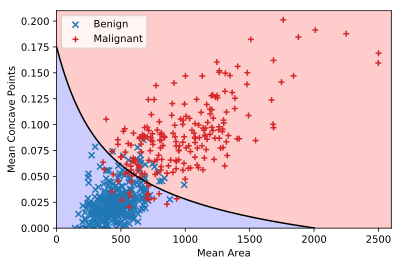

In [ ]:
model = SVC(kernel='linear', C=0.1)
Phi = poly_feat(norm.fit_transform(X), 10)
model.fit(Phi, y)
plot_classification_sklearn(model, norm, lambda X : poly_feat(X, 10))

Let's also look at how RBF features perform.  First let's consider a grid over the state space (remember that in the above, we have transformed the features to be normalized between $[-1,1]$, so we place the centers over this space.

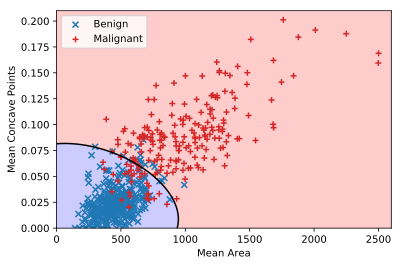

In [ ]:
XY = np.meshgrid(np.linspace(-1,1,10), np.linspace(-1,1,10))
mu = np.array([XY[0].ravel(), XY[1].ravel()]).T
sig = np.sqrt(np.median(sqdist(mu,mu)))

model = SVC(kernel='linear', C=10.0)
Phi = rbf_feat(norm.fit_transform(X), mu, sig)
model.fit(Phi, y)
plot_classification_sklearn(model, norm, lambda X : rbf_feat(X, mu, sig))

Let's alternatively see what this look like if we pick 50 random data points as our centers.

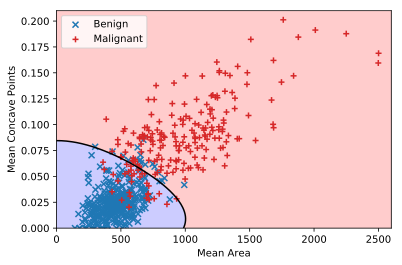

In [ ]:
X_ = norm.fit_transform(X)
np.random.seed(0)
p = np.random.permutation(X.shape[0])
mu = X_[p[:50],:]
sig = np.sqrt(np.median(sqdist(mu,mu)))

model = SVC(kernel='linear', C=10.0)
Phi = rbf_feat(norm.fit_transform(X), mu, sig)
model.fit(Phi, y)
plot_classification_sklearn(model, norm, lambda X : rbf_feat(X, mu, sig))

Looks about as good, with the added benefit that we don't need to worry about covering the whole space, and considering points such as the bottom right and top left with no data.

Finally, let's consider some of the kernel-based functions.  Here we're going to just use the kernel classifiers built by scikit learn, but by combining the kernel section above with the explicit code in the previous sections, it would be straightforward to write our own implementation as well.  First let's start with the polynomial kernel.  Note that in addition to adding the `degree=d` parameter, you'll want to set the `coef0=1.0` parameter to include the constant term `1` in the kernel function (without this, the polynomial kernel only has terms of degree _exactly_ $d$, and typically performs quite poorly.

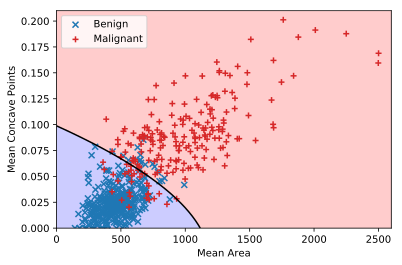

In [ ]:
model = SVC(kernel='poly', C=100.0, degree=2, coef0=1.0)
model.fit(norm.fit_transform(X), y)
plot_classification_sklearn(model, norm, lambda X : X)

Finally, let's try the RBF kernel, first with the median trick to select bandwidth.

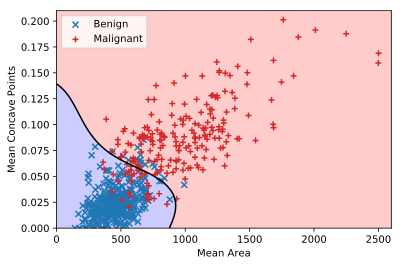

In [ ]:
# scikit-learn uses gamma = 1/(2*sig^2) parameterization
X_ = norm.fit_transform(X)
gamma = 1/(2*np.median(sqdist(X_, X_)))
model = SVC(kernel='rbf', C=10.0, gamma = gamma)
model.fit(norm.fit_transform(X), y)
plot_classification_sklearn(model, norm, lambda X : X)

And finally, because all these example admittedly look fairly similar (the decision boundary _is_ roughly linear with some noise, after all), let's consider a case where we make the bandwidth small enough so that the method is guaranteed overfit to the training data.  Here we make the bandwidth very small (i.e. $\gamma$ large), and the regularization small, so that the classifier actually managed to get 100% accuracy on the training data (of course with very poor generalization performance.

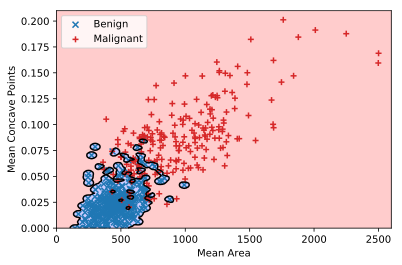

In [ ]:
# scikit-learn uses gamma = 1/(2*sig^2) parameterization
X_ = norm.fit_transform(X)
gamma = 1000/(2*np.median(sqdist(X_, X_)))
model = SVC(kernel='rbf', C=100.0, gamma = gamma)
model.fit(norm.fit_transform(X), y)
plot_classification_sklearn(model, norm, lambda X : X)

The important thing to keep in mind through all this is how the nonlinear features and hyperparameter settings with influence the ability of functions to represent complex data and to overfit and underfit to the data.  And of course, when using scikit learn, you'll need to understand the documentation to the point where you see how the hyperparameters of the class of interest map to the parameters that you actually want to control.  This usually requires going through the documentation a fair amount, but it's quite important, and the default parameters are often quite poor.